# Why Batch Normalization?
One way to make deep networks easier to train is to use more sophisticated optimization procedures such as SGD+momentum, RMSProp, or Adam. Another strategy is to change the architecture of the network to make it easier to train. One idea along these lines is batch normalization which was recently proposed by [3].

The idea is relatively straightforward. Machine learning methods tend to work better when their input data consists of uncorrelated features with zero mean and unit variance. When training a neural network, we can preprocess the data before feeding it to the network to explicitly decorrelate its features; this will ensure that the first layer of the network sees data that follows a nice distribution. However even if we preprocess the input data, the activations at deeper layers of the network will likely no longer be decorrelated and will no longer have zero mean or unit variance since they are output from earlier layers in the network. Even worse, during the training process the distribution of features at each layer of the network will shift as the weights of each layer are updated.

The authors of [3] hypothesize that the shifting distribution of features inside deep neural networks may make training deep networks more difficult. To overcome this problem, [3] proposes to insert batch normalization layers into the network. At training time, a batch normalization layer uses a minibatch of data to estimate the mean and standard deviation of each feature. These estimated means and standard deviations are then used to center and normalize the features of the minibatch. A running average of these means and standard deviations is kept during training, and at test time these running averages are used to center and normalize features.

It is possible that this normalization strategy could reduce the representational power of the network, since it may sometimes be optimal for certain layers to have features that are not zero-mean or unit variance. To this end, the batch normalization layer includes learnable shift and scale parameters for each feature dimension.

[3] Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.

In [53]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from utils.data_utils import get_CIFAR10_data

%matplotlib inline


def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [54]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_val:  (1000, 3, 32, 32)
y_test:  (1000,)
y_train:  (49000,)
X_train:  (49000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)


## Batch normalization: Forward

In [55]:
def batchnorm_forward(x, gamma, beta, bn_param):
    """
    Forward pass for batch normalization.
    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the
    mean and variance of each feature, and these averages are used to normalize
    data at test-time.
    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:
    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var
    Note that the batch normalization paper suggests a different test-time
    behavior: they compute sample mean and variance for each feature using a
    large number of training images rather than using a running average. For
    this implementation we have chosen to use running averages instead since
    they do not require an additional estimation step; the torch7
    implementation of batch normalization also uses running averages.
    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features
    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = x.shape
    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == 'train':
        
        # Take sample mean & var of our minibatch across each dimension.
        sample_mean = np.mean(x, axis=0)
        sample_var = np.var(x, axis=0)

        # Normalise our batch then shift and scale with gamma/beta.
        normalized_data = (x - sample_mean) / np.sqrt(sample_var + eps)
        out = gamma * normalized_data + beta

        # Update our running mean and variance then store.
        running_mean = momentum * running_mean + (1 - momentum) * sample_mean
        running_var = momentum * running_var + (1 - momentum) * sample_var
        bn_param['running_mean'] = running_mean
        bn_param['running_var'] = running_var

        # Store intermediate results needed for backward pass.
        cache = {
            'x_minus_mean': (x - sample_mean),
            'normalized_data': normalized_data,
            'gamma': gamma,
            'ivar': 1./np.sqrt(sample_var + eps),
            'sqrtvar': np.sqrt(sample_var + eps),
        }

    elif mode == 'test':
        #######################################################################
        # Implementing the test-time forward pass for batch normalization. #
        # Use the running mean and variance to normalize the incoming data,   #
        # then scale and shift the normalized data using gamma and beta.      #
        # Store the result in the out variable.                               #
        #######################################################################

        # Test time batch norm using learned gamma/beta and calculated running mean/var.
        out = (gamma / (np.sqrt(running_var + eps)) * x) + (beta - (gamma*running_mean)/np.sqrt(running_var + eps))

    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

    return out, cache




In [56]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization

# Simulate the forward pass for a two-layer network
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print('  means: ', a.mean(axis=0))
print('  stds: ', a.std(axis=0))

# Means should be close to zero and stds close to one
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print('  mean: ', a_norm.mean(axis=0))
print('  std: ', a_norm.std(axis=0))

# Now means should be close to beta and stds close to gamma
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print('After batch normalization (nontrivial gamma, beta)')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

Before batch normalization:
  means:  [-14.30885459 -23.66268893  28.48942441]
  stds:  [ 36.07225394  41.4027619   26.92896548]
After batch normalization (gamma=1, beta=0)
  mean:  [ -2.25375274e-16   1.11022302e-18   5.51780843e-16]
  std:  [ 1.          1.          0.99999999]
After batch normalization (nontrivial gamma, beta)
  means:  [ 11.  12.  13.]
  stds:  [ 1.          1.99999999  2.99999998]


In [57]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)
for t in range(50):
  X = np.random.randn(N, D1)
  a = np.maximum(0, X.dot(W1)).dot(W2)
  batchnorm_forward(a, gamma, beta, bn_param)
bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

After batch normalization (test-time):
  means:  [ 0.05149203  0.05173538  0.12158094]
  stds:  [ 1.04409127  0.9254658   1.02533515]


## Batch Normalization: backward

check out this beutiful tutorial of backward pass of BN
https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html

In [58]:
def batchnorm_backward(dout, cache):
    """
    Backward pass for batch normalization.
    For this implementation, you should write out a computation graph for
    batch normalization on paper and propagate gradients backward through
    intermediate nodes.
    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.
    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None

    # Get cached results from the forward pass.
    N, D = dout.shape
    normalized_data = cache.get('normalized_data')
    gamma = cache.get('gamma')
    ivar = cache.get('ivar')
    x_minus_mean = cache.get('x_minus_mean')
    sqrtvar = cache.get('sqrtvar')

    # Backprop dout to calculate dbeta and dgamma.
    dbeta = np.sum(dout, axis=0)
    dgamma = np.sum(dout * normalized_data, axis=0)

    # Carry on the backprop in steps to calculate dx.
    # Step9
    dxhat = dout*gamma
    # Step8
    dxmu1 = dxhat*ivar
    # Step7
    divar = np.sum(dxhat*x_minus_mean, axis=0)
    # Step6
    dsqrtvar = divar * (-1/sqrtvar**2)
    # Step5
    dvar = dsqrtvar * 0.5 * (1/sqrtvar)
    # Step4
    dsq = (1/N)*dvar*np.ones_like(dout)
    # Step3
    dxmu2 = dsq * 2 * x_minus_mean
    # Step2
    dx1 = dxmu1 + dxmu2
    dmu = -1*np.sum(dxmu1 + dxmu2, axis=0)
    # Step1
    dx2 = (1/N)*dmu*np.ones_like(dout)
    # Step0
    dx = dx2 + dx1

    return dx, dgamma, dbeta

In [59]:
def eval_numerical_gradient_array(f, x, df, h=1e-5):
  """
  Evaluate a numeric gradient for a function that accepts a numpy
  array and returns a numpy array.
  """
  grad = np.zeros_like(x)
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:
    ix = it.multi_index
    
    oldval = x[ix]
    x[ix] = oldval + h
    pos = f(x).copy()
    x[ix] = oldval - h
    neg = f(x).copy()
    x[ix] = oldval
    
    grad[ix] = np.sum((pos - neg) * df) / (2 * h)
    it.iternext()
  return grad


In [60]:
def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
  """ 
  a naive implementation of numerical gradient of f at x 
  - f should be a function that takes a single argument
  - x is the point (numpy array) to evaluate the gradient at
  """ 

  fx = f(x) # evaluate function value at original point
  grad = np.zeros_like(x)
  # iterate over all indexes in x
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:

    # evaluate function at x+h
    ix = it.multi_index
    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evalute f(x + h)
    x[ix] = oldval - h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # restore

    # compute the partial derivative with centered formula
    grad[ix] = (fxph - fxmh) / (2 * h) # the slope
    if verbose:
      print(ix, grad[ix])
    it.iternext() # step to next dimension

  return grad


In [61]:
# Gradient check batchnorm backward pass

N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  6.63113152062e-10
dgamma error:  7.77707150185e-12
dbeta error:  6.70746431764e-11


## Fully Connected Nets with Batch Normalization


## Implementation of previously coded functions, Affine Batchnorm ReLu Forward together in one function

In [62]:
def affine_forward(x, w, b):
  """
  Computes the forward pass for an affine (fully-connected) layer.

  The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
  examples, where each example x[i] has shape (d_1, ..., d_k). We will
  reshape each input into a vector of dimension D = d_1 * ... * d_k, and
  then transform it to an output vector of dimension M.

  Inputs:
  - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
  - w: A numpy array of weights, of shape (D, M)
  - b: A numpy array of biases, of shape (M,)
  
  Returns a tuple of:
  - out: output, of shape (N, M)
  - cache: (x, w, b)
  """
  out = None
  out = x.reshape(x.shape[0], w.shape[0]).dot(w) + b
  cache = (x, w, b)
  return out, cache


def affine_backward(dout, cache):
  """
  Computes the backward pass for an affine layer.

  Inputs:
  - dout: Upstream derivative, of shape (N, M)
  - cache: Tuple of:
    - x: Input data, of shape (N, d_1, ... d_k)
    - w: Weights, of shape (D, M)

  Returns a tuple of:
  - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
  - dw: Gradient with respect to w, of shape (D, M)
  - db: Gradient with respect to b, of shape (M,)
  """
  x, w, b = cache
  dx, dw, db = None, None, None
  dw = x.reshape(x.shape[0], w.shape[0]).T.dot(dout)
  db = np.sum(dout, axis=0)
  dx = dout.dot(w.T).reshape(x.shape)
  return dx, dw, db


def relu_forward(x):
  """
  Computes the forward pass for a layer of rectified linear units (ReLUs).

  Input:
  - x: Inputs, of any shape

  Returns a tuple of:
  - out: Output, of the same shape as x
  - cache: x
  """
  out = None
  out = np.maximum(0, x)
  cache = x
  return out, cache

def relu_backward(dout, cache):
  """
  Computes the backward pass for a layer of rectified linear units (ReLUs).

  Input:
  - dout: Upstream derivatives, of any shape
  - cache: Input x, of same shape as dout

  Returns:
  - dx: Gradient with respect to x
  """
  dx, x = None, cache
  dx = dout
  dx[cache < 0] = 0
  return dx

def affine_relu_forward(x, w, b):
  """
  Convenience layer that perorms an affine transform followed by a ReLU

  Inputs:
  - x: Input to the affine layer
  - w, b: Weights for the affine layer

  Returns a tuple of:
  - out: Output from the ReLU
  - cache: Object to give to the backward pass
  """
  a, fc_cache = affine_forward(x, w, b)
  out, relu_cache = relu_forward(a)
  cache = (fc_cache, relu_cache)
  return out, cache


def affine_relu_backward(dout, cache):
  """
  Backward pass for the affine-relu convenience layer
  """
  fc_cache, relu_cache = cache
  da = relu_backward(dout, relu_cache)
  dx, dw, db = affine_backward(da, fc_cache)
  return dx, dw, db



def affine_norm_relu_forward(x, w, b, gamma, beta, bn_params):
  """
  Convenience layer that combines affine transform, batch normalization and ReLU
  Inputs:
  - x: Input to the affine layer
  - w, b: Weights for the affine layer
  - gamma, beta: Weights for the normalization layer
  Returns a tuple of:
  - out: Output from the ReLU
  - cache: Object to give to the backward pass
  """
  a1, fc_cache = affine_forward(x, w, b)
  a2, bn_cache = batchnorm_forward(a1, gamma, beta, bn_params)
  out, relu_cache = relu_forward(a2)
  cache = (fc_cache, bn_cache, relu_cache)
  return out, cache

def affine_norm_relu_backward(dout, cache):
  """
  Backwardpass for the affine-norm-ReLU convenience layer
  """
  fc_cache, bn_cache, relu_cache = cache
  da2 = relu_backward(dout, relu_cache)
  da1, dgamma, dbeta = batchnorm_backward(da2, bn_cache)
  dx, dw, db = affine_backward(da1, fc_cache)
  return dx, dw, db, dgamma, dbeta

def getsoftmaxloss(x, y):
  """
  Computes the loss and gradient for softmax classification.

  Inputs:
  - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
    for the ith input.
  - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
    0 <= y[i] < C

  Returns a tuple of:
  - loss: Scalar giving the loss
  - dx: Gradient of the loss with respect to x
  """
  probs = np.exp(x - np.max(x, axis=1, keepdims=True))
  probs /= np.sum(probs, axis=1, keepdims=True)
  N = x.shape[0]
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N
  dx = probs.copy()
  dx[np.arange(N), y] -= 1
  dx /= N
  return loss, dx


## Fully connected net with batch normalization

In [63]:
class FullyConnectedNet(object):
    """
    A fully-connected neural network with an arbitrary number of hidden layers,
    ReLU nonlinearities, and a softmax loss function. This will also implement
    dropout and batch normalization as options. For a network with L layers,
    the architecture will be
    {affine - [batch norm] - relu - [dropout]} x (L - 1) - affine - softmax
    where batch normalization and dropout are optional, and the {...} block is
    repeated L - 1 times.
    Similar to the TwoLayerNet above, learnable parameters are stored in the
    self.params dictionary and will be learned using the Solver class.
    """

    def __init__(self, hidden_dims, input_dim=3 * 32 * 32, num_classes=10,
                 dropout=0, use_batchnorm=False, reg=0.0,
                 weight_scale=1e-2, dtype=np.float32, seed=None):
        """
        Initialize a new FullyConnectedNet.
        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - dropout: Scalar between 0 and 1 giving dropout strength. If dropout=0 then
          the network should not use dropout at all.
        - use_batchnorm: Whether or not the network should use batch normalization.
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
          this datatype. float32 is faster but less accurate, so you should use
          float64 for numeric gradient checking.
        - seed: If not None, then pass this random seed to the dropout layers. This
          will make the dropout layers deteriminstic so we can gradient check the
          model.
        """
        self.use_batchnorm = use_batchnorm
        self.use_dropout = dropout > 0
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        #######################################################################
        # Initializing the parameters of the network, storing all values in    #
        # the self.params dictionary. Store weights and biases for the first layer #
        # in W1 and b1; for the second layer use W2 and b2, etc. Weights should be #
        # initialized from a normal distribution with standard deviation equal to  #
        # weight_scale and biases should be initialized to zero.                   #
        #                                                                          #
        # When using batch normalization, store scale and shift parameters for the #
        # first layer in gamma1 and beta1; for the second layer use gamma2 and     #
        # beta2, etc. Scale parameters should be initialized to one and shift      #
        # parameters should be initialized to zero.                                #
        #######################################################################
        if type(hidden_dims) != list:
            raise ValueError('hidden_dim has to be a list')

        self.L = len(hidden_dims) + 1
        self.N = input_dim
        self.C = num_classes
        dims = [self.N] + hidden_dims + [self.C]
        Ws = {'W' + str(i + 1):
              weight_scale * np.random.randn(dims[i], dims[i + 1]) for i in range(len(dims) - 1)}
        b = {'b' + str(i + 1): np.zeros(dims[i + 1])
             for i in range(len(dims) - 1)}

        self.params.update(b)
        self.params.update(Ws)

        # When using dropout we need to pass a dropout_param dictionary to each
        # dropout layer so that the layer knows the dropout probability and the mode
        # (train / test). You can pass the same dropout_param to each dropout layer.

        self.dropout_param = {}
        if self.use_dropout:
            self.dropout_param = {'mode': 'train', 'p': dropout}
            print('We use dropout with p =%f' % (self.dropout_param['p']))
            if seed is not None:
                self.dropout_param['seed'] = seed

        # With batch normalization we need to keep track of running means and
        # variances, so we need to pass a special bn_param object to each batch
        # normalization layer. You should pass self.bn_params[0] to the forward pass
        # of the first batch normalization layer, self.bn_params[1] to the forward
        # pass of the second batch normalization layer, etc.

        if self.use_batchnorm:
            print('We use batchnorm here')
            self.bn_params = {'bn_param' + str(i + 1): {'mode': 'train',
                                                        'running_mean': np.zeros(dims[i + 1]),
                                                        'running_var': np.zeros(dims[i + 1])}
                              for i in range(len(dims) - 2)}
            gammas = {'gamma' + str(i + 1):
                      np.ones(dims[i + 1]) for i in range(len(dims) - 2)}
            betas = {'beta' + str(i + 1): np.zeros(dims[i + 1])
                     for i in range(len(dims) - 2)}

            self.params.update(betas)
            self.params.update(gammas)
        # Cast all parameters to the correct datatype
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)

    def loss(self, X, y=None):
        """
        Compute loss and gradient for the fully-connected net.
        Input / output: Same as TwoLayerNet above.
        """
        X = X.astype(self.dtype)
        mode = 'test' if y is None else 'train'

        # Set train/test mode for batchnorm params and dropout param since they
        # behave differently during training and testing.
        if self.dropout_param is not None:
            self.dropout_param['mode'] = mode
        if self.use_batchnorm:
            for key, bn_param in self.bn_params.items():
                bn_param[mode] = mode

        #######################################################################
        # Implementing the forward pass for the fully-connected net, computing  #
        # the class scores for X and storing them in the scores variable.          #
        #                                                                          #
        # When using dropout, we'll need to pass self.dropout_param to each       #
        # dropout forward pass.                                                    #
        #                                                                          #
        # When using batch normalization, we'll need to pass self.bn_params[0] to #
        # the forward pass for the first batch normalization layer, pass           #
        # self.bn_params[1] to the forward pass for the second batch normalization #
        # layer, etc.                                                              #
        #######################################################################

        # We are gonna store everythin in a dictionnary hidden
        hidden = {}
        hidden['h0'] = X.reshape(X.shape[0], np.prod(X.shape[1:]))
        if self.use_dropout:
            # dropout on the input layer
            hdrop, cache_hdrop = dropout_forward(
                hidden['h0'], self.dropout_param)
            hidden['hdrop0'], hidden['cache_hdrop0'] = hdrop, cache_hdrop

        for i in range(self.L):
            idx = i + 1
            # Naming of the variable
            w = self.params['W' + str(idx)]
            b = self.params['b' + str(idx)]
            h = hidden['h' + str(idx - 1)]
            if self.use_dropout:
                h = hidden['hdrop' + str(idx - 1)]
            if self.use_batchnorm and idx != self.L:
                gamma = self.params['gamma' + str(idx)]
                beta = self.params['beta' + str(idx)]
                bn_param = self.bn_params['bn_param' + str(idx)]

            # Computing of the forward pass.
            # Special case of the last layer (output)
            if idx == self.L:
                h, cache_h = affine_forward(h, w, b)
                hidden['h' + str(idx)] = h
                hidden['cache_h' + str(idx)] = cache_h

            # For all other layers
            else:
                if self.use_batchnorm:
                    h, cache_h = affine_norm_relu_forward(
                        h, w, b, gamma, beta, bn_param)
                    hidden['h' + str(idx)] = h
                    hidden['cache_h' + str(idx)] = cache_h
                else:
                    h, cache_h = affine_relu_forward(h, w, b)
                    hidden['h' + str(idx)] = h
                    hidden['cache_h' + str(idx)] = cache_h

                if self.use_dropout:
                    h = hidden['h' + str(idx)]
                    hdrop, cache_hdrop = dropout_forward(h, self.dropout_param)
                    hidden['hdrop' + str(idx)] = hdrop
                    hidden['cache_hdrop' + str(idx)] = cache_hdrop

        scores = hidden['h' + str(self.L)]

        # If test mode return early
        if mode == 'test':
            return scores

        loss, grads = 0.0, {}

        #######################################################################
        # Implementing the backward pass for the fully-connected net. Store the #
        # loss in the loss variable and gradients in the grads dictionary. Compute #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        #                                                                          #
        # When using batch normalization, you don't need to regularize the scale   #
        # and shift parameters.Good to know                                        #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        #######################################################################

        # Computing of the loss
        data_loss, dscores = getsoftmaxloss(scores, y)
        reg_loss = 0
        for w in [self.params[f] for f in self.params.keys() if f[0] == 'W']:
            reg_loss += 0.5 * self.reg * np.sum(w * w)

        loss = data_loss + reg_loss

        # Backward pass

        hidden['dh' + str(self.L)] = dscores
        for i in range(self.L)[::-1]:
            idx = i + 1
            dh = hidden['dh' + str(idx)]
            h_cache = hidden['cache_h' + str(idx)]
            if idx == self.L:
                dh, dw, db = affine_backward(dh, h_cache)
                hidden['dh' + str(idx - 1)] = dh
                hidden['dW' + str(idx)] = dw
                hidden['db' + str(idx)] = db

            else:
                if self.use_dropout:
                    # First backprop in the dropout layer
                    cache_hdrop = hidden['cache_hdrop' + str(idx)]
                    dh = dropout_backward(dh, cache_hdrop)
                if self.use_batchnorm:
                    dh, dw, db, dgamma, dbeta = affine_norm_relu_backward(
                        dh, h_cache)
                    hidden['dh' + str(idx - 1)] = dh
                    hidden['dW' + str(idx)] = dw
                    hidden['db' + str(idx)] = db
                    hidden['dgamma' + str(idx)] = dgamma
                    hidden['dbeta' + str(idx)] = dbeta
                else:
                    dh, dw, db = affine_relu_backward(dh, h_cache)
                    hidden['dh' + str(idx - 1)] = dh
                    hidden['dW' + str(idx)] = dw
                    hidden['db' + str(idx)] = db

        # w gradients where we add the regulariation term
        list_dw = {key[1:]: val + self.reg * self.params[key[1:]]
                   for key, val in hidden.items() if key[:2] == 'dW'}
        # Paramerters b
        list_db = {key[1:]: val for key, val in hidden.items() if key[:2] ==
                   'db'}
        # Parameters gamma
        list_dgamma = {key[1:]: val for key, val in hidden.items() if key[
            :6] == 'dgamma'}
        # Paramters beta
        list_dbeta = {key[1:]: val for key, val in hidden.items() if key[
            :5] == 'dbeta'}

        grads = {}
        grads.update(list_dw)
        grads.update(list_db)
        grads.update(list_dgamma)
        grads.update(list_dbeta)
        return loss, grads


In [64]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            use_batchnorm=True)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  if reg == 0: print

Running check with reg =  0
We use batchnorm here
Initial loss:  2.14207253625
W1 relative error: 2.90e-05
W2 relative error: 1.32e-05
W3 relative error: 4.18e-10
b1 relative error: 2.22e-03
b2 relative error: 2.22e-03
b3 relative error: 1.21e-10
beta1 relative error: 4.80e-09
beta2 relative error: 4.29e-08
gamma1 relative error: 4.96e-09
gamma2 relative error: 3.14e-08
Running check with reg =  3.14
We use batchnorm here
Initial loss:  6.9322873521
W1 relative error: 2.56e-06
W2 relative error: 1.09e-05
W3 relative error: 1.51e-07
b1 relative error: 5.55e-09
b2 relative error: 2.22e-08
b3 relative error: 1.79e-10
beta1 relative error: 1.51e-08
beta2 relative error: 8.05e-09
gamma1 relative error: 1.12e-08
gamma2 relative error: 2.97e-09


# Batchnorm for deep networks
Run the following to train a six-layer network on a subset of 1000 training examples both with and without batch normalization.

## First implementing solver as before

In [65]:

from utils import optim
class Solver(object):
  """
  A Solver encapsulates all the logic necessary for training classification
  models. The Solver performs stochastic gradient descent using different
  update rules defined in optim.py.

  The solver accepts both training and validataion data and labels so it can
  periodically check classification accuracy on both training and validation
  data to watch out for overfitting.

  To train a model, you will first construct a Solver instance, passing the
  model, dataset, and various optoins (learning rate, batch size, etc) to the
  constructor. You will then call the train() method to run the optimization
  procedure and train the model.
  
  After the train() method returns, model.params will contain the parameters
  that performed best on the validation set over the course of training.
  In addition, the instance variable solver.loss_history will contain a list
  of all losses encountered during training and the instance variables
  solver.train_acc_history and solver.val_acc_history will be lists containing
  the accuracies of the model on the training and validation set at each epoch.
  
  Example usage might look something like this:
  
  data = {
    'X_train': # training data
    'y_train': # training labels
    'X_val': # validation data
    'X_train': # validation labels
  }
  model = MyAwesomeModel(hidden_size=100, reg=10)
  solver = Solver(model, data,
                  update_rule='sgd',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  lr_decay=0.95,
                  num_epochs=10, batch_size=100,
                  print_every=100)
  solver.train()


  A Solver works on a model object that must conform to the following API:

  - model.params must be a dictionary mapping string parameter names to numpy
    arrays containing parameter values.

  - model.loss(X, y) must be a function that computes training-time loss and
    gradients, and test-time classification scores, with the following inputs
    and outputs:

    Inputs:
    - X: Array giving a minibatch of input data of shape (N, d_1, ..., d_k)
    - y: Array of labels, of shape (N,) giving labels for X where y[i] is the
      label for X[i].

    Returns:
    If y is None, run a test-time forward pass and return:
    - scores: Array of shape (N, C) giving classification scores for X where
      scores[i, c] gives the score of class c for X[i].

    If y is not None, run a training time forward and backward pass and return
    a tuple of:
    - loss: Scalar giving the loss
    - grads: Dictionary with the same keys as self.params mapping parameter
      names to gradients of the loss with respect to those parameters.
  """

  def __init__(self, model, data, **kwargs):
    """
    Construct a new Solver instance.
    
    Required arguments:
    - model: A model object conforming to the API described above
    - data: A dictionary of training and validation data with the following:
      'X_train': Array of shape (N_train, d_1, ..., d_k) giving training images
      'X_val': Array of shape (N_val, d_1, ..., d_k) giving validation images
      'y_train': Array of shape (N_train,) giving labels for training images
      'y_val': Array of shape (N_val,) giving labels for validation images
      
    Optional arguments:
    - update_rule: A string giving the name of an update rule in optim.py.
      Default is 'sgd'.
    - optim_config: A dictionary containing hyperparameters that will be
      passed to the chosen update rule. Each update rule requires different
      hyperparameters (see optim.py) but all update rules require a
      'learning_rate' parameter so that should always be present.
    - lr_decay: A scalar for learning rate decay; after each epoch the learning
      rate is multiplied by this value.
    - batch_size: Size of minibatches used to compute loss and gradient during
      training.
    - num_epochs: The number of epochs to run for during training.
    - print_every: Integer; training losses will be printed every print_every
      iterations.
    - verbose: Boolean; if set to false then no output will be printed during
      training.
    """
    self.model = model
    self.X_train = data['X_train']
    self.y_train = data['y_train']
    self.X_val = data['X_val']
    self.y_val = data['y_val']
    
    # Unpack keyword arguments
    self.update_rule = kwargs.pop('update_rule', 'sgd')
    self.optim_config = kwargs.pop('optim_config', {})
    self.lr_decay = kwargs.pop('lr_decay', 1.0)
    self.batch_size = kwargs.pop('batch_size', 100)
    self.num_epochs = kwargs.pop('num_epochs', 10)

    self.print_every = kwargs.pop('print_every', 10)
    self.verbose = kwargs.pop('verbose', True)

    # Throw an error if there are extra keyword arguments
    if len(kwargs) > 0:
      extra = ', '.join('"%s"' % k for k in kwargs.keys())
      raise ValueError('Unrecognized arguments %s' % extra)

    # Make sure the update rule exists, then replace the string
    # name with the actual function
    if not hasattr(optim, self.update_rule):
      raise ValueError('Invalid update_rule "%s"' % self.update_rule)
    self.update_rule = getattr(optim, self.update_rule)

    self._reset()


  def _reset(self):
    """
    Set up some book-keeping variables for optimization. Don't call this
    manually.
    """
    # Set up some variables for book-keeping
    self.epoch = 0
    self.best_val_acc = 0
    self.best_params = {}
    self.loss_history = []
    self.train_acc_history = []
    self.val_acc_history = []

    # Make a deep copy of the optim_config for each parameter
    self.optim_configs = {}
    for p in self.model.params:
      d = {k: v for k, v in self.optim_config.items()}
      self.optim_configs[p] = d


  def _step(self):
    """
    Make a single gradient update. This is called by train() and should not
    be called manually.
    """
    # Make a minibatch of training data
    num_train = self.X_train.shape[0]
    batch_mask = np.random.choice(num_train, self.batch_size)
    X_batch = self.X_train[batch_mask]
    y_batch = self.y_train[batch_mask]

    # Compute loss and gradient
    loss, grads = self.model.loss(X_batch, y_batch)
    self.loss_history.append(loss)

    # Perform a parameter update
    for p, w in self.model.params.items():
      dw = grads[p]
      config = self.optim_configs[p]
      next_w, next_config = self.update_rule(w, dw, config)
      self.model.params[p] = next_w
      self.optim_configs[p] = next_config


  def check_accuracy(self, X, y, num_samples=None, batch_size=100):
    """
    Check accuracy of the model on the provided data.
    
    Inputs:
    - X: Array of data, of shape (N, d_1, ..., d_k)
    - y: Array of labels, of shape (N,)
    - num_samples: If not None, subsample the data and only test the model
      on num_samples datapoints.
    - batch_size: Split X and y into batches of this size to avoid using too
      much memory.
      
    Returns:
    - acc: Scalar giving the fraction of instances that were correctly
      classified by the model.
    """
    
    # Maybe subsample the data
    N = X.shape[0]
    if num_samples is not None and N > num_samples:
      mask = np.random.choice(N, num_samples)
      N = num_samples
      X = X[mask]
      y = y[mask]

    # Compute predictions in batches
    num_batches = N / batch_size
    if N % batch_size != 0:
      num_batches += 1
    y_pred = []
    for i in range(int(num_batches)):
      start = i * batch_size
      end = (i + 1) * batch_size
      scores = self.model.loss(X[start:end])
      y_pred.append(np.argmax(scores, axis=1))
    y_pred = np.hstack(y_pred)
    acc = np.mean(y_pred == y)

    return acc


  def train(self):
    """
    Run optimization to train the model.
    """
    num_train = self.X_train.shape[0]
    iterations_per_epoch = max(num_train / self.batch_size, 1)
    num_iterations = self.num_epochs * iterations_per_epoch
    num_iterations = int(num_iterations)
    for t in range(num_iterations):
      self._step()

      # Maybe print training loss
      if self.verbose and t % self.print_every == 0:
        print('(Iteration %d / %d) loss: %f' % (
               t + 1, num_iterations, self.loss_history[-1]))

      # At the end of every epoch, increment the epoch counter and decay the
      # learning rate.
      epoch_end = (t + 1) % iterations_per_epoch == 0
      if epoch_end:
        self.epoch += 1
        for k in self.optim_configs:
          self.optim_configs[k]['learning_rate'] *= self.lr_decay

      # Check train and val accuracy on the first iteration, the last
      # iteration, and at the end of each epoch.
      first_it = (t == 0)
      last_it = (t == num_iterations + 1)
      if first_it or last_it or epoch_end:
        train_acc = self.check_accuracy(self.X_train, self.y_train,
                                        num_samples=1000)
        val_acc = self.check_accuracy(self.X_val, self.y_val)
        self.train_acc_history.append(train_acc)
        self.val_acc_history.append(val_acc)

        if self.verbose:
          print('(Epoch %d / %d) train acc: %f; val_acc: %f' % (
                 self.epoch, self.num_epochs, train_acc, val_acc))

        # Keep track of the best model
        if val_acc > self.best_val_acc:
          self.best_val_acc = val_acc
          self.best_params = {}
          for k, v in self.model.params.items():
            self.best_params[k] = v.copy()

    # At the end of training swap the best params into the model
    self.model.params = self.best_params



In [66]:
# Try training a very deep net with batchnorm
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
bn_solver.train()

solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
solver.train()

We use batchnorm here
(Iteration 1 / 200) loss: 2.268808
(Epoch 0 / 10) train acc: 0.141000; val_acc: 0.136000
(Epoch 1 / 10) train acc: 0.351000; val_acc: 0.290000
(Epoch 2 / 10) train acc: 0.400000; val_acc: 0.277000
(Epoch 3 / 10) train acc: 0.458000; val_acc: 0.281000
(Epoch 4 / 10) train acc: 0.575000; val_acc: 0.319000
(Epoch 5 / 10) train acc: 0.601000; val_acc: 0.315000
(Epoch 6 / 10) train acc: 0.630000; val_acc: 0.316000
(Epoch 7 / 10) train acc: 0.676000; val_acc: 0.318000
(Epoch 8 / 10) train acc: 0.707000; val_acc: 0.345000
(Epoch 9 / 10) train acc: 0.759000; val_acc: 0.324000
(Epoch 10 / 10) train acc: 0.805000; val_acc: 0.351000
(Iteration 1 / 200) loss: 2.302965
(Epoch 0 / 10) train acc: 0.114000; val_acc: 0.088000
(Epoch 1 / 10) train acc: 0.229000; val_acc: 0.216000
(Epoch 2 / 10) train acc: 0.312000; val_acc: 0.245000
(Epoch 3 / 10) train acc: 0.320000; val_acc: 0.264000
(Epoch 4 / 10) train acc: 0.366000; val_acc: 0.284000
(Epoch 5 / 10) train acc: 0.384000; val_acc

Run the following to visualize the results from two networks trained above. You should find that using batch normalization helps the network to converge much faster.

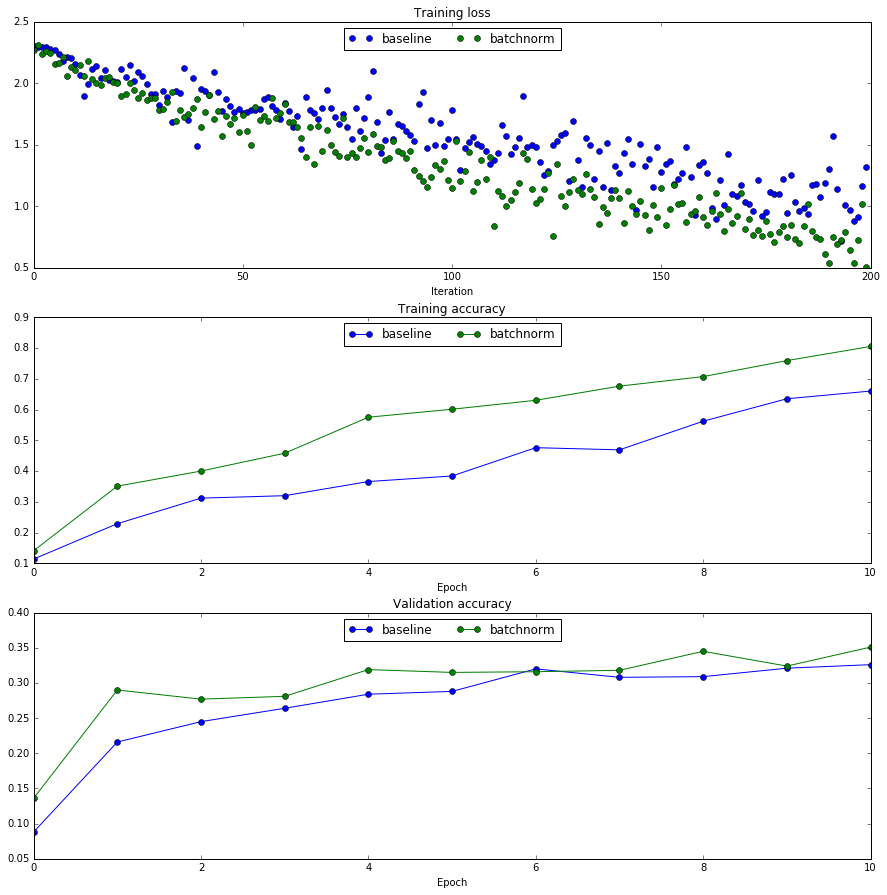

In [67]:
plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(solver.loss_history, 'o', label='baseline')
plt.plot(bn_solver.loss_history, 'o', label='batchnorm')

plt.subplot(3, 1, 2)
plt.plot(solver.train_acc_history, '-o', label='baseline')
plt.plot(bn_solver.train_acc_history, '-o', label='batchnorm')

plt.subplot(3, 1, 3)
plt.plot(solver.val_acc_history, '-o', label='baseline')
plt.plot(bn_solver.val_acc_history, '-o', label='batchnorm')
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Batch normalization and initialization
We will now run a small experiment to study the interaction of batch normalization and weight initialization.

The first cell will train 8-layer networks both with and without batch normalization using different scales for weight initialization. The second layer will plot training accuracy, validation set accuracy, and training loss as a function of the weight initialization scale.

In [68]:
# Try training a very deep net with batchnorm
hidden_dims = [50, 50, 50, 50, 50, 50, 50]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

bn_solvers = {}
solvers = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
  print('Running weight scale %d / %d' % (i + 1, len(weight_scales)))
  bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
  model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

  bn_solver = Solver(bn_model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
  bn_solver.train()
  bn_solvers[weight_scale] = bn_solver

  solver = Solver(model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
  solver.train()
  solvers[weight_scale] = solver

Running weight scale 1 / 20
We use batchnorm here
Running weight scale 2 / 20
We use batchnorm here
Running weight scale 3 / 20
We use batchnorm here
Running weight scale 4 / 20
We use batchnorm here
Running weight scale 5 / 20
We use batchnorm here
Running weight scale 6 / 20
We use batchnorm here
Running weight scale 7 / 20
We use batchnorm here
Running weight scale 8 / 20
We use batchnorm here
Running weight scale 9 / 20
We use batchnorm here
Running weight scale 10 / 20
We use batchnorm here
Running weight scale 11 / 20
We use batchnorm here
Running weight scale 12 / 20
We use batchnorm here
Running weight scale 13 / 20
We use batchnorm here
Running weight scale 14 / 20
We use batchnorm here
Running weight scale 15 / 20
We use batchnorm here
Running weight scale 16 / 20
We use batchnorm here


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\ipykernel\__main__.py:153: RuntimeWarning: divide by zero encountered in log


Running weight scale 17 / 20
We use batchnorm here
Running weight scale 18 / 20
We use batchnorm here
Running weight scale 19 / 20
We use batchnorm here
Running weight scale 20 / 20
We use batchnorm here


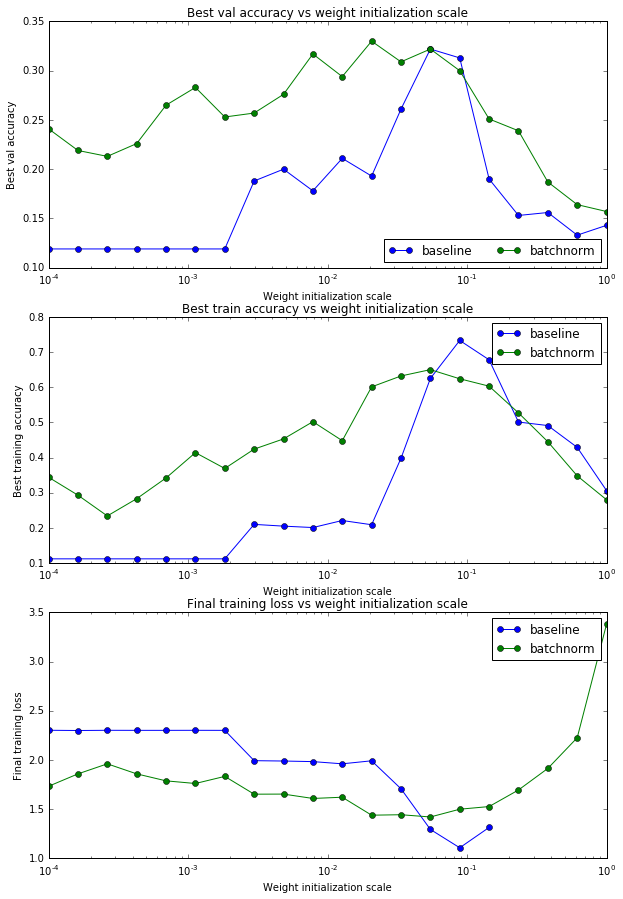

In [69]:
# Plot results of weight scale experiment
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
  best_train_accs.append(max(solvers[ws].train_acc_history))
  bn_best_train_accs.append(max(bn_solvers[ws].train_acc_history))
  
  best_val_accs.append(max(solvers[ws].val_acc_history))
  bn_best_val_accs.append(max(bn_solvers[ws].val_acc_history))
  
  final_train_loss.append(np.mean(solvers[ws].loss_history[-100:]))
  bn_final_train_loss.append(np.mean(bn_solvers[ws].loss_history[-100:]))
  
plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()

plt.gcf().set_size_inches(10, 15)
plt.show()

# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. 

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

# Dropout forward pass

In [70]:
def dropout_forward(x, dropout_param):
    """
    Performs the forward pass for (inverted) dropout.
    Inputs:
    - x: Input data, of any shape
    - dropout_param: A dictionary with the following keys:
      - p: Dropout parameter. We drop each neuron output with probability p.
      - mode: 'test' or 'train'. If the mode is train, then perform dropout;
        if the mode is test, then just return the input.
      - seed: Seed for the random number generator. Passing seed makes this
        function deterministic, which is needed for gradient checking but not in
        real networks.
    Outputs:
    - out: Array of the same shape as x.
    - cache: A tuple (dropout_param, mask). In training mode, mask is the dropout
      mask that was used to multiply the input; in test mode, mask is None.
    """

    p, mode = dropout_param['p'], dropout_param['mode']
    if 'seed' in dropout_param:
        np.random.seed(dropout_param['seed'])

    mask = None
    out = None

    if mode == 'train':
        #######################################################################
        # TODO: Implement the training phase forward pass for inverted dropout.   #
        # Store the dropout mask in the mask variable.                            #
        #######################################################################
        mask = (np.random.rand(*x.shape) < p) / p
        out = x * mask

    elif mode == 'test':
        ###################################################################
        # TODO: Implement the test phase forward pass for inverted dropout.       #
        ###################################################################
        mask = None
        out = x

    cache = (dropout_param, mask)
    out = out.astype(x.dtype, copy=False)

    return out, cache


In [71]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())


Running tests with p =  0.3
Mean of input:  10.0007105313
Mean of train-time output:  9.97211152616
Mean of test-time output:  10.0007105313
Fraction of train-time output set to zero:  0.700956
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.6
Mean of input:  10.0007105313
Mean of train-time output:  10.0054057383
Mean of test-time output:  10.0007105313
Fraction of train-time output set to zero:  0.399848
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.75
Mean of input:  10.0007105313
Mean of train-time output:  9.99286760507
Mean of test-time output:  10.0007105313
Fraction of train-time output set to zero:  0.250708
Fraction of test-time output set to zero:  0.0


# Dropout backward pass

In [72]:
def dropout_backward(dout, cache):
    """
    Perform the backward pass for (inverted) dropout.
    Inputs:
    - dout: Upstream derivatives, of any shape
    - cache: (dropout_param, mask) from dropout_forward.
    """
    dropout_param, mask = cache
    mode = dropout_param['mode']

    dx = None
    if mode == 'train':
        #######################################################################
        # TODO: Implement the training phase backward pass for inverted dropout.  #
        #######################################################################
        dx = dout * mask

    elif mode == 'test':
        dx = dout
    return dx

In [73]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.44561126195e-11


# Fully-connected nets with Dropout


In [75]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))


Running check with dropout =  0
Initial loss:  2.3051948274
W1 relative error: 2.53e-07
W2 relative error: 1.50e-05
W3 relative error: 2.75e-07
b1 relative error: 2.94e-06
b2 relative error: 5.05e-08
b3 relative error: 1.17e-10
Running check with dropout =  0.25
We use dropout with p =0.250000
Initial loss:  2.30543020584
W1 relative error: 1.67e-10
W2 relative error: 2.43e-09
W3 relative error: 2.91e-08
b1 relative error: 3.84e-10
b2 relative error: 1.07e-10
b3 relative error: 1.89e-10
Running check with dropout =  0.5
We use dropout with p =0.500000
Initial loss:  2.3075515208
W1 relative error: 2.01e-08
W2 relative error: 7.87e-09
W3 relative error: 7.76e-08
b1 relative error: 3.05e-09
b2 relative error: 6.51e-10
b3 relative error: 1.00e-10


In [77]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.75]
for dropout in dropout_choices:
    
  # dropout is already implemented in FullyConnectedNet
  model = FullyConnectedNet([500], dropout=dropout)
  print(dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

0
(Iteration 1 / 125) loss: 8.596245
(Epoch 0 / 25) train acc: 0.224000; val_acc: 0.183000


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\ipykernel\__main__.py:153: RuntimeWarning: divide by zero encountered in log


(Epoch 1 / 25) train acc: 0.382000; val_acc: 0.219000
(Epoch 2 / 25) train acc: 0.484000; val_acc: 0.248000
(Epoch 3 / 25) train acc: 0.620000; val_acc: 0.274000
(Epoch 4 / 25) train acc: 0.648000; val_acc: 0.246000
(Epoch 5 / 25) train acc: 0.724000; val_acc: 0.281000
(Epoch 6 / 25) train acc: 0.784000; val_acc: 0.302000
(Epoch 7 / 25) train acc: 0.822000; val_acc: 0.259000
(Epoch 8 / 25) train acc: 0.840000; val_acc: 0.271000
(Epoch 9 / 25) train acc: 0.892000; val_acc: 0.285000
(Epoch 10 / 25) train acc: 0.914000; val_acc: 0.294000
(Epoch 11 / 25) train acc: 0.954000; val_acc: 0.271000
(Epoch 12 / 25) train acc: 0.950000; val_acc: 0.273000
(Epoch 13 / 25) train acc: 0.966000; val_acc: 0.290000
(Epoch 14 / 25) train acc: 0.976000; val_acc: 0.297000
(Epoch 15 / 25) train acc: 0.984000; val_acc: 0.303000
(Epoch 16 / 25) train acc: 0.974000; val_acc: 0.280000
(Epoch 17 / 25) train acc: 0.984000; val_acc: 0.281000
(Epoch 18 / 25) train acc: 0.980000; val_acc: 0.282000
(Epoch 19 / 25) tra

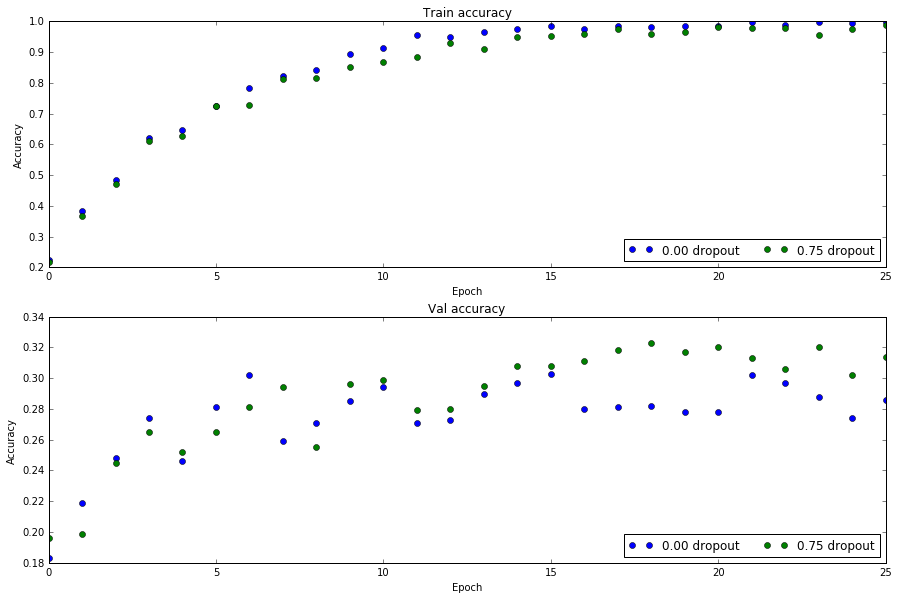

In [78]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()